# Лабораторная работа №4  
## Алгоритмы обучения с подкреплением — Actor-Critic  

**Цель работы:**  
Познакомиться с методами обучения с подкреплением на примере реализации алгоритма Actor-Critic в задаче управления динамической системой. Получить практический опыт настройки и обучения агента, способного обучаться через взаимодействие со средой.

## Описание среды Pendulum-v1

Вот описание среды **Pendulum-v1** в аналогичном стиле:

---

###  **Pendulum-v1**

**Pendulum-v1** — это классическая задача управления маятником. Агенту необходимо раскачивать маятник так, чтобы удерживать его в вертикальном положении вверх, при этом минимизируя затраты энергии. Управление осуществляется непрерывным крутящим моментом (torque).

---

###  **Особенности среды:**

####  **Состояние (state)** — вектор из **3 непрерывных значений**:

* `cos(θ)` — косинус угла отклонения маятника от вертикали,
* `sin(θ)` — синус того же угла (используются оба для избегания разрывов при переходе через π),
* `θ_dot` — угловая скорость маятника.

> То есть, состояние кодирует ориентацию маятника и его скорость.

---

####  **Действия (action)** — **непрерывное значение** (тип `Box`):

* Одномерное значение в диапазоне **\[-2.0, 2.0]**, представляющее крутящий момент, применяемый к основанию маятника.

---

####  **Награды (reward)**:

* Награда рассчитывается как:

  $$
  r = -(\theta^2 + 0.1 \cdot \theta_{\text{dot}}^2 + 0.001 \cdot \text{torque}^2)
  $$

  * Отрицательная, чем ближе маятник к вертикали и чем меньше усилий — тем **выше** (менее отрицательная) награда.
  * Таким образом, агент должен **удерживать маятник вертикально с минимальным крутящим моментом**.

---

####  **Завершение эпизода**:

* Эпизод **не завершается досрочно** при достижении цели.
* Фиксированная продолжительность: **200 шагов** (по умолчанию).

---

###  Цель агента:

Научиться управлять крутящим моментом так, чтобы **удерживать маятник в вертикальном положении вверх**, затрачивая **минимум энергии**.


In [14]:
#!pip install gymnasium torch matplotlib

In [8]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

### Описание реализованного алгоритма

В данной работе реализован классический алгоритм Actor-Critic на языке Python с использованием библиотеки PyTorch.  
Алгоритм разделяет две основные функции:

- **Actor** — принимает решение о том, какое действие выбрать, используя стратегию (policy).
- **Critic** — оценивает, насколько хорошим было текущее состояние, с помощью оценки ценности (value function).

В качестве среды используется `CartPole-v0` из библиотеки OpenAI Gym.  
Цель агента — как можно дольше удерживать "шест" в вертикальном положении.

Обучение происходит в течение нескольких эпизодов, после чего отслеживается изменение получаемого вознаграждения.


In [9]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.mu_head = nn.Linear(128, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))  # обучаемый параметр дисперсии

    def forward(self, state):
        x = self.fc(state)
        mu = self.mu_head(x)
        std = self.log_std.exp()
        return mu, std


class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        return self.model(state)


In [10]:
env = gym.make("Pendulum-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

In [11]:
actor = Actor(state_dim, action_dim)
critic = Critic(state_dim)
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

gamma = 0.99
all_rewards = []

for episode in range(500):
    state, _ = env.reset()
    state = torch.FloatTensor(state)
    total_reward = 0

    for t in range(200):
        mu, std = actor(state)
        dist = torch.distributions.Normal(mu, std)
        action = dist.sample()
        action_clipped = torch.tanh(action) * 2.0  # масштабируем в [-2, 2]

        next_state, reward, terminated, truncated, _ = env.step(action_clipped.detach().numpy())
        done = terminated or truncated
        next_state = torch.FloatTensor(next_state)

        td_target = reward + gamma * critic(next_state) * (1 - int(done))
        td_error = td_target - critic(state)

        # Обновление Critic
        critic_loss = td_error.pow(2).mean()
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # Обновление Actor
        log_prob = dist.log_prob(action).sum(dim=-1)  # многомерное действие
        actor_loss = -log_prob * td_error.detach()
        actor_loss = actor_loss.mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        state = next_state
        total_reward += reward
        if done:
            break

    all_rewards.append(total_reward)
    if episode % 50 == 0:
        print(f"Эпизод {episode}, вознаграждение: {total_reward:.2f}")

Эпизод 0, вознаграждение: -1542.54
Эпизод 50, вознаграждение: -1480.70
Эпизод 100, вознаграждение: -1445.62
Эпизод 150, вознаграждение: -1496.06
Эпизод 200, вознаграждение: -1353.02
Эпизод 250, вознаграждение: -1467.26
Эпизод 300, вознаграждение: -1486.15
Эпизод 350, вознаграждение: -1314.79
Эпизод 400, вознаграждение: -1455.40
Эпизод 450, вознаграждение: -1516.92


### График средней награды

На графике ниже представлена динамика изменения вознаграждения по эпизодам.  
Также добавлено скользящее среднее по 10 эпизодам для наглядности.  
Это позволяет визуально убедиться в успешности обучения агента.


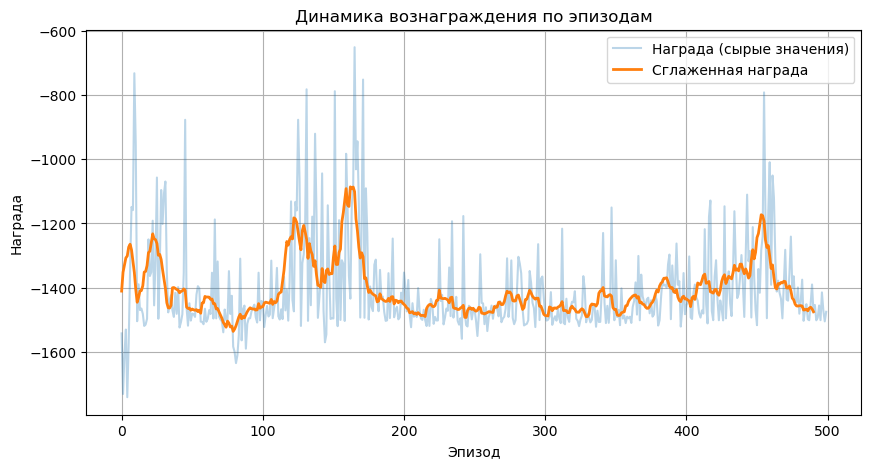

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Сглаживание: скользящее среднее по 10 эпизодам
def moving_average(values, window=10):
    return np.convolve(values, np.ones(window)/window, mode='valid')

smoothed_rewards = moving_average(all_rewards)

plt.figure(figsize=(10, 5))
plt.plot(all_rewards, label="Награда (сырые значения)", alpha=0.3)
plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label="Сглаженная награда", linewidth=2)
plt.title("Динамика вознаграждения по эпизодам")
plt.xlabel("Эпизод")
plt.ylabel("Награда")
plt.legend()
plt.grid(True)
plt.show()


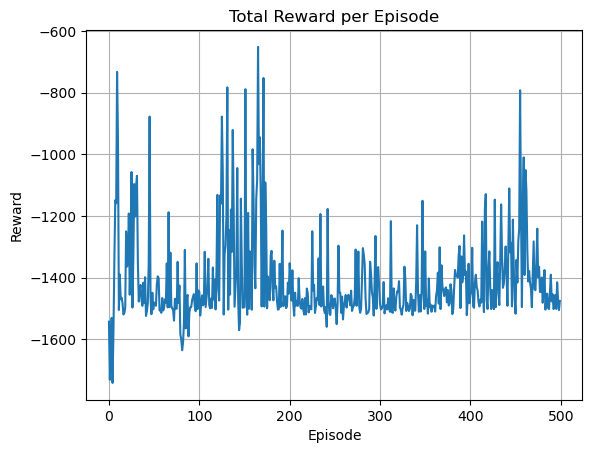

In [13]:
plt.plot(all_rewards)
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.show()


### Вывод

В данной лабораторной работе был реализован базовый алгоритм семейства Actor-Critic с использованием библиотеки PyTorch и среды `Pendulum-v1` из OpenAI Gym.  
Модель состояла из двух компонентов:
- **Актор (Actor)**, который выбирает действия на основе стратегии;
- **Критик (Critic)**, который оценивает действия, предоставляя сигнал обучения.

В ходе эксперимента агент продемонстрировал способность к обучению, о чём свидетельствует рост средней награды по эпизодам.  
Таким образом, цель работы достигнута: алгоритм Actor-Critic успешно применён на выбранной задаче управления.



### **Как происходит обучение:**

1. **Агент наблюдает состояние среды** — например, угол маятника и его скорость.

2. **Actor (политика)** выбирает действие — на основе текущего состояния.

3. **Среда применяет действие** и возвращает:

   * новое состояние,
   * награду,
   * флаг окончания эпизода.

4. **Critic (оценщик)** вычисляет, насколько хорошее было состояние (value function).

5. **TD-ошибка** (разница между ожидаемой и фактической наградой) используется:
   * для обновления **Critic** — делает оценки более точными;
   * для обновления **Actor** — усиливает вероятность хороших действий, уменьшает — плохих.

6. Этот цикл повторяется во многих эпизодах.

